
# Convolution / Image Blur Linear-Gaussian Example: EP vs EUP

This notebook accompanies a theoretical description of the convolution/image-blur forward operator and a reproducible experiment comparing the _Expected Posterior (EP)_ and the _Expected Unnormalized Posterior (EUP)_ when the forward map is replaced by a stochastic surrogate with **additive output uncertainty**.

**What this notebook does**
- Constructs a structured 1D convolution operator `G` (discrete blur) that models smoothing/ill-posed forward maps common in imaging and inverse problems.
- Sets up a linear-Gaussian inverse problem y = G u + eps, with Gaussian prior on u and Gaussian observation noise.
- Models a stochastic surrogate by adding bias r and Gaussian output perturbation eta ~ N(0, Q) so that the surrogate output is G u + r + eta.
- Computes EP moments (mixture of posteriors) and EUP (marginalized likelihood leading to inflated observation covariance).
- Demonstrates comparison plots and quantitative metrics (KL divergence estimate, mean & covariance errors, coverage).

The notebook is self-contained and numerically reproducible.



## Part A — Motivation and construction of the convolution / blur operator

**Motivation (applications):**
- Many inverse problems in imaging, tomography, geophysics, and remote sensing are smoothing operations: the quantity of interest `u` (e.g., an image or spatial field) is convolved with a point-spread function (PSF), sensor response, or Green's function. The forward operator `G` often has decaying singular values, making the inverse problem ill-posed: small noise in observations or small modeling errors can cause large uncertainty in recovered `u` in certain subspaces.
- A convolutional blur operator is a canonical, simple, and physically motivated forward map that captures smoothing and local correlation structure while being easy to implement and parametrize (kernel width, boundary conditions, downsampling).
- Studying surrogate uncertainty (e.g., due to approximate optics, truncated numerical solvers, or learned surrogates) interacting with such smoothing helps understand realistic inference behavior: which directions of `u` are sensitive to surrogate error, and how EP/EUP handle that uncertainty.

**Specifics of the 1D convolution operator used here:**
- We treat `u` as a length-`d` vector representing values on a regularly spaced grid (1D signal or flattened image row/column).
- The forward operator `G` maps `u` to observations at the same grid (no downsampling), defined by discrete convolution with a kernel `k` (point-spread function). In matrix form, `G` is a Toeplitz (or circulant) matrix representing linear convolution.
- Kernel choice: we use a Gaussian kernel (discrete samples of a Gaussian function) parameterized by a standard deviation `sigma_kernel`. The Gaussian kernel models typical optical point-spread functions and smoothing in many physical systems.
- Boundary conditions: we present two common choices — periodic (circular convolution) which yields a circulant `G` (diagonalizable by the DFT), and zero-padding (non-circulant Toeplitz), which is more physical for finite images but slightly more expensive to represent as a dense matrix.
- Why these choices:
  - Gaussian kernel: smooth, isotropic blur that decays with distance — matches many sensor PSFs.
  - Periodic convolution is numerically convenient (fast via FFT), and reveals spectral structure (singular values relate to kernel's DFT).
  - Zero-padding is physically relevant for finite domains where convolution outside domain is zero.

**Parameterization useful for experiments:**
- `d` (dimension of `u`): choose values like 32, 64, 128 to test scaling.
- `sigma_kernel`: controls degree of smoothing; larger values → stronger ill-posedness (faster singular-value decay).
- Low-rank or localized perturbations of surrogate noise `Q` can be used to study effects concentrated in specific spectral components (e.g., high-frequency uncertainty vs low-frequency).


In [1]:

# Helper functions for convolution operator and utilities
import numpy as np, scipy.linalg as sla
from scipy.fft import fft, ifft, fftfreq

def gaussian_kernel(length, sigma, centered=True):
    # return a discrete Gaussian kernel of length `length` and std `sigma`
    x = np.arange(length)
    if centered:
        half = length // 2
        x_shift = (x - half)
    else:
        x_shift = x
    k = np.exp(-0.5 * (x_shift / sigma)**2)
    k = k / np.sum(k)
    return k

def circulant_conv_matrix(k):
    d = len(k)
    first_row = np.roll(k, 0)
    cols = [np.roll(first_row, i) for i in range(d)]
    return np.vstack(cols).T

def apply_circ_conv(u, k):
    # circular convolution via FFT
    return np.fft.ifft(np.fft.fft(k) * np.fft.fft(u)).real

def toeplitz_conv_matrix(k):
    d = len(k)
    G = np.zeros((d, d))
    for i in range(d):
        for j in range(d):
            idx = i - j
            if 0 <= idx < d:
                G[i,j] = k[idx]
    return G



### Notes on spectral structure and ill-posedness

- For circulant convolution with a Gaussian kernel, `G` is diagonalized by the discrete Fourier transform. The eigenvalues are the DFT of the kernel. For a smooth kernel, its DFT decays at high frequencies, meaning small singular values in directions corresponding to high-frequency components of `u` — these directions are poorly informed by data (ill-posedness).


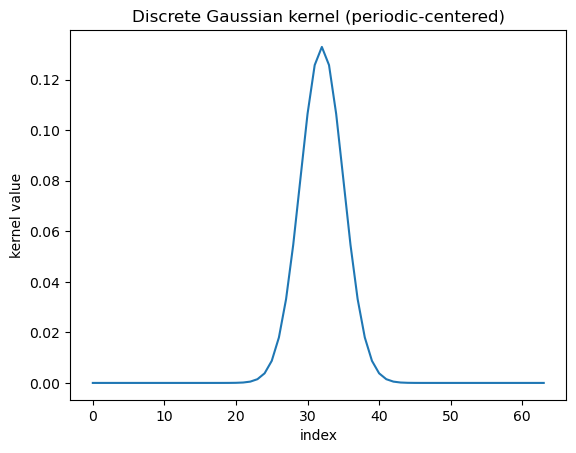

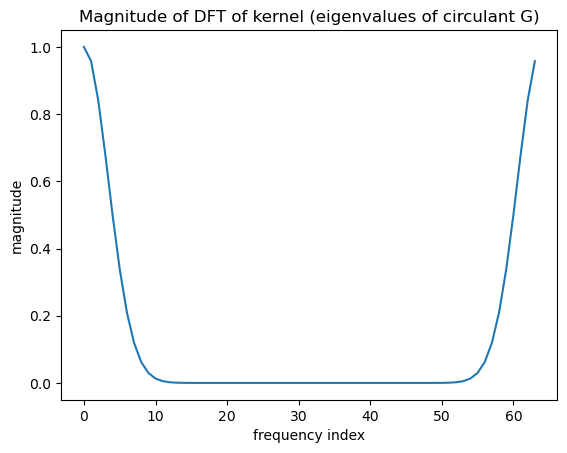

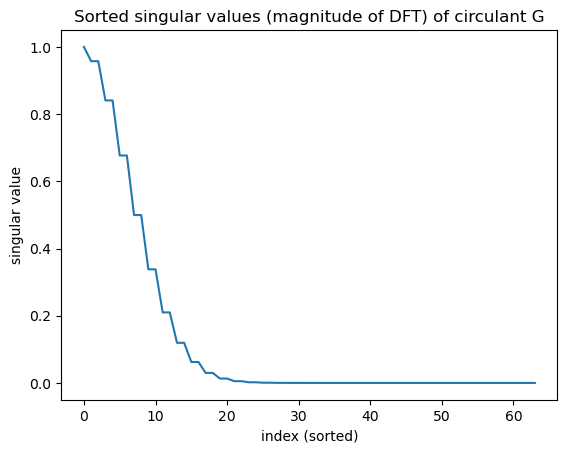

In [10]:

# Demonstrate kernel and spectrum
d = 64
sigma_kernel = 3.0
k = gaussian_kernel(d, sigma_kernel, centered=True)
G_circ = circulant_conv_matrix(k)
eigvals = np.fft.fft(k)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(d), k)
plt.title('Discrete Gaussian kernel (periodic-centered)')
plt.xlabel('index')
plt.ylabel('kernel value')
plt.show()

plt.figure()
plt.plot(np.arange(d), np.abs(eigvals))
plt.title('Magnitude of DFT of kernel (eigenvalues of circulant G)')
plt.xlabel('frequency index')
plt.ylabel('magnitude')
plt.show()

svals = np.sort(np.abs(eigvals))[::-1]
plt.figure()
plt.plot(svals)
plt.title('Sorted singular values (magnitude of DFT) of circulant G')
plt.xlabel('index (sorted)')
plt.ylabel('singular value')
plt.show()



## Linear-Gaussian inverse problem and surrogate model

We consider the linear model
y = G u + eps, eps ~ N(0, Sigma), u ~ N(m0, C0).

Surrogate (additive-output) model: for each surrogate draw the forward output is
G_* u = G u + r + eta, eta ~ N(0, Q).

For a fixed surrogate realization eta, likelihood is N(y | G u + r + eta, Sigma) and the posterior is Gaussian with covariance
C = (C0^{-1} + G^T Sigma^{-1} G)^{-1}
(independent of eta in this additive-output surrogate). Posterior mean is linear in eta.

- EP: mixture of Gaussians E_eta[N(m_eta, C)].
- EUP: marginalize eta to get N(y | G u + r, Sigma+Q) and compute posterior with inflated noise covariance.


In [11]:

# Linear-Gaussian utilities

import numpy as np, scipy.linalg as sla

def compute_post_cov(C0, G, Sigma):
    C0i = sla.inv(C0)
    Si = sla.inv(Sigma)
    A = C0i + G.T @ Si @ G
    return sla.inv(A)

def compute_post_mean(C, C0, m0, G, Sigma, y, r=None, eta=None):
    rhs = sla.inv(C0) @ m0 + G.T @ sla.inv(Sigma) @ (y - (r if r is not None else 0.0) - (eta if eta is not None else 0.0))
    return C @ rhs

def EP_moments(C, C0, m0, G, Sigma, y, r, Q):
    C0i = sla.inv(C0)
    Si = sla.inv(Sigma)
    mean_EP = C @ (C0i @ m0 + G.T @ Si @ (y - r))
    between = C @ G.T @ Si @ Q @ Si @ G @ C
    cov_EP = C + between
    return mean_EP, cov_EP

def EUP_posterior(C0, m0, G, Sigma, y, r, Q):
    Sbar = Sigma + Q
    Cbar = compute_post_cov(C0, G, Sbar)
    mean_bar = Cbar @ (sla.inv(C0) @ m0 + G.T @ sla.inv(Sbar) @ (y - r))
    return mean_bar, Cbar

def sample_EP_via_mixture(C, C0, m0, G, Sigma, y, r, Q, M=500, samples_per_component=10):
    d = G.shape[1]
    samples = []
    etas = np.random.multivariate_normal(np.zeros(Q.shape[0]), Q, size=M)
    Si = sla.inv(Sigma)
    C0i = sla.inv(C0)
    for i in range(M):
        eta = etas[i]
        mean_i = C @ (C0i @ m0 + G.T @ Si @ (y - r - eta))
        s = np.random.multivariate_normal(mean_i, C, size=samples_per_component)
        samples.append(s)
    samples = np.vstack(samples)
    return samples

def EP_log_pdf(X, C, C0, m0, G, Sigma, y, r, Q, M=200):
    d = X.shape[1]
    etas = np.random.multivariate_normal(np.zeros(Q.shape[0]), Q, size=M)
    Si = sla.inv(Sigma)
    C0i = sla.inv(C0)
    Lc = sla.cholesky(C, lower=True)
    const = -0.5 * d * np.log(2*np.pi) - np.log(np.linalg.det(Lc))
    log_components = np.zeros((X.shape[0], M))
    invC = sla.inv(C)
    for j in range(M):
        eta = etas[j]
        mean_j = C @ (C0i @ m0 + G.T @ Si @ (y - r - eta))
        diff = X - mean_j[None,:]
        quad = -0.5 * np.sum(diff @ invC * diff, axis=1)
        log_components[:, j] = const + quad
    a = np.max(log_components, axis=1, keepdims=True)
    lse = a + np.log(np.sum(np.exp(log_components - a), axis=1, keepdims=True))
    logpdf = (lse - np.log(M)).ravel()
    return logpdf

def estimate_KL_EP_to_EUP(C, C0, m0, G, Sigma, y, r, Q, QapproxM=300, samples_M=2000):
    samples = sample_EP_via_mixture(C, C0, m0, G, Sigma, y, r, Q, M=QapproxM, samples_per_component=max(1, samples_M//QapproxM))
    logEP = EP_log_pdf(samples, C, C0, m0, G, Sigma, y, r, Q, M=QapproxM)
    mean_eup, C_eup = EUP_posterior(C0, m0, G, Sigma, y, r, Q)
    invCe = sla.inv(C_eup)
    L = sla.cholesky(C_eup, lower=True)
    const_e = -0.5 * samples.shape[1] * np.log(2*np.pi) - np.log(np.linalg.det(L))
    diffs = samples - mean_eup[None,:]
    quad_e = -0.5 * np.sum(diffs @ invCe * diffs, axis=1)
    logEUP = const_e + quad_e
    return np.mean(logEP - logEUP), np.std(logEP - logEUP) / np.sqrt(len(logEP))



## Run a reproducible example: compare EP vs EUP for a blur operator


In [17]:
gaussian_kernel(3, 3, centered=True)

# circulant_conv_matrix(k)

array([0.32710442, 0.34579116, 0.32710442])

In [ ]:

import numpy as np, scipy.linalg as sla, matplotlib.pyplot as plt

# Parameters
d = 64
sigma_kernel = 3.0
k = gaussian_kernel(d, sigma_kernel, centered=True)
G = circulant_conv_matrix(k)

# prior
alpha = 1.0
C0 = alpha * np.eye(d)
m0 = np.zeros(d)

# observation noise
sigma_obs = 0.1
Sigma = (sigma_obs**2) * np.eye(d)

# true u and y
u_true = np.zeros(d)
u_true[d//4:d//4+6] = 1.0
y = apply_circ_conv(u_true, k) + np.random.multivariate_normal(np.zeros(d), Sigma)

# surrogate
r = np.zeros(d); r[d//2:d//2+4] = 0.05
q_scale = 0.05
Q_full = (q_scale**2) * np.eye(d)
# low-rank Q in Fourier basis
freqs = np.fft.fftfreq(d)
hf_mask = np.abs(freqs) > 0.12
F = np.fft.fft(np.eye(d)) / np.sqrt(d)
lam = np.zeros(d)
lam[hf_mask] = (q_scale**2) * 5.0
Q_lowrank = np.real_if_close(F.conj().T @ np.diag(lam) @ F)

# compute posteriors
C = compute_post_cov(C0, G, Sigma)
mean_EP, cov_EP = EP_moments(C, C0, m0, G, Sigma, y, r, Q_full)
mean_eup, cov_eup = EUP_posterior(C0, m0, G, Sigma, y, r, Q_full)
print('Posterior (fixed) cov trace:', np.trace(C))
print('EP cov trace:', np.trace(cov_EP))
print('EUP cov trace:', np.trace(cov_eup))

# sample mixture and plot marginal at a coord
coord = d//4
samples_EP = sample_EP_via_mixture(C, C0, m0, G, Sigma, y, r, Q_full, M=400, samples_per_component=4)
samples_EUP = np.random.multivariate_normal(mean_eup, cov_eup, size=2000)
plt.figure()
plt.hist(samples_EP[:, coord], bins=80, density=True, alpha=0.5)
plt.hist(samples_EUP[:, coord], bins=80, density=True, alpha=0.5)
plt.title(f'Marginal at coord {coord}: EP (mixture) vs EUP (Gaussian)')
plt.xlabel('u_coord value'); plt.ylabel('density'); plt.show()

# posterior mean comparison
plt.figure()
plt.plot(mean_EP, label='EP mean')
plt.plot(mean_eup, label='EUP mean')
plt.plot(u_true, '--', label='u_true')
plt.title('Posterior means: EP vs EUP'); plt.xlabel('index'); plt.ylabel('value'); plt.legend(); plt.show()
# KL estimate
kl_est, kl_se = estimate_KL_EP_to_EUP(C, C0, m0, G, Sigma, y, r, Q_full, QapproxM=300, samples_M=1800)
print(f'Estimated KL(EP || EUP) = {kl_est:.4f} +/- {1.96*kl_se:.4f} (approx)')

# low-rank comparison traces
mean_EP_lr, cov_EP_lr = EP_moments(C, C0, m0, G, Sigma, y, r, Q_lowrank)
mean_eup_lr, cov_eup_lr = EUP_posterior(C0, m0, G, Sigma, y, r, Q_lowrank)
print('Low-rank Q traces: EP trace, EUP trace =', np.trace(cov_EP_lr), np.trace(cov_eup_lr))
# trace vs q_scale
q_vals = np.logspace(-3, -0.5, 8)
traces_EP = []; traces_EUP = []
for qv in q_vals:
    Qv = (qv**2) * np.eye(d)
    _, cov_epv = EP_moments(C, C0, m0, G, Sigma, y, r, Qv)
    _, cov_eupv = EUP_posterior(C0, m0, G, Sigma, y, r, Qv)
    traces_EP.append(np.trace(cov_epv)); traces_EUP.append(np.trace(cov_eupv))
plt.figure(); plt.semilogx(q_vals, traces_EP, marker='o', label='EP trace'); plt.semilogx(q_vals, traces_EUP, marker='x', label='EUP trace'); plt.title('Trace vs q (full-rank Q)'); plt.xlabel('q'); plt.ylabel('trace(cov)'); plt.legend(); plt.show()



## Notes and next steps

- This notebook illustrates how additive-output surrogate uncertainty enters EP and EUP in a structured convolution example. The analytic EP moments (mean and covariance) are straightforward because the component posterior covariance does not depend on surrogate draw for this surrogate model.
- In more general surrogate models (e.g., random operator perturbations G_* = G + Delta), both posterior mean and covariance will depend on surrogate draws, and EP becomes a mixture of Gaussians with varying covariances — numerically tractable but more expensive.
- Suggested extensions:
  - Use zero-padding Toeplitz convolution to examine boundary effects.
  - Downsample observations to increase ill-posedness.
  - Use a GP surrogate for a nonlinear forward map and repeat the comparison (EUP often corresponds to adding GP predictive variance into observation noise).


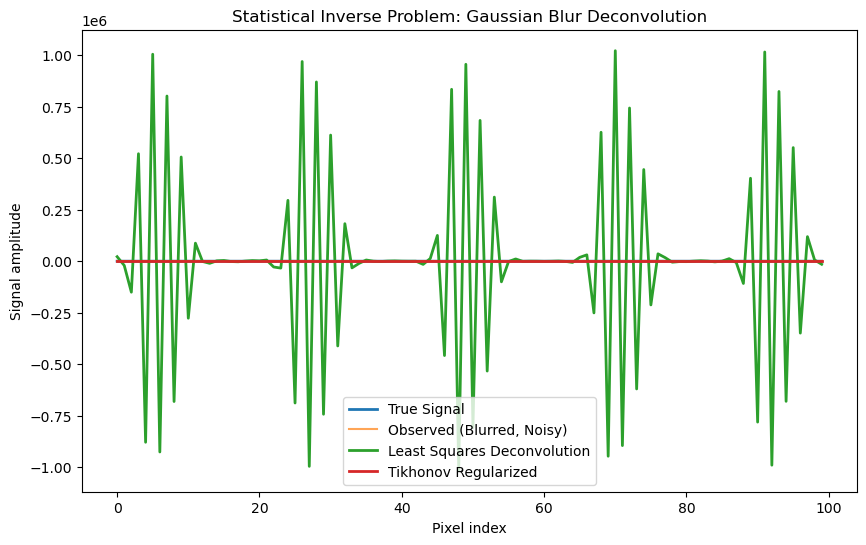

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

def gaussian_kernel(size, sigma):
    """Create a normalized Gaussian kernel (discrete)."""
    x = np.arange(size) - size // 2
    kernel = np.exp(-0.5 * (x / sigma) ** 2)
    kernel /= kernel.sum()
    return kernel

# --- 1. Problem Setup --- #
# (A) True signal (step function with sharp edges)
n = 100
u_true = np.zeros(n)
u_true[30:70] = 1.0

# (B) Define Gaussian PSF
psf_size = 21
sigma = 3.0
psf = gaussian_kernel(psf_size, sigma)
psf /= psf.sum()  # Normalize kernel

# (C) Linear (not cyclic) convolution -- 'full' mode
y_blur = np.convolve(u_true, psf, mode='full') # length n + psf_size - 1

# Crop central part: mimic "same" mode
start = psf_size//2
end = start + n
y_blur = y_blur[start:end]  # size n

# (D) Add Gaussian noise
noise_level = 0.05
np.random.seed(42)
y_obs = y_blur + noise_level * np.random.randn(n)

# --- 2. Construct Forward Matrix G (Toeplitz) --- #
# Toeplitz convolution operator (linear convolution)
# Each row = shifted version of psf, zero-padded for edges

col = np.zeros(n)
col[:psf_size//2+1] = psf[psf_size//2::-1]   # from center to left
row = np.zeros(n)
row[:psf_size//2+1] = psf[psf_size//2:]      # from center to right
G = toeplitz(col, row)  # Shape (n, n)

# --- 3. Inverse Problem (Least Squares & Regularized) --- #
# (A) Simple least squares solution
u_ls, res, rank, s = np.linalg.lstsq(G, y_obs, rcond=None)

# (B) Regularized (Tikhonov/Ridge) solution
alpha = 0.1  # Regularization parameter
GtG = G.T @ G
I = np.eye(n)
u_reg = np.linalg.solve(GtG + alpha*I, G.T @ y_obs)

# --- 4. Display Results --- #
plt.figure(figsize=(10,6))
plt.plot(u_true, label='True Signal', lw=2)
plt.plot(y_obs, label='Observed (Blurred, Noisy)', alpha=0.7)
plt.plot(u_ls, label='Least Squares Deconvolution', lw=2)
plt.plot(u_reg, label='Tikhonov Regularized', lw=2)
plt.legend()
plt.xlabel("Pixel index")
plt.ylabel("Signal amplitude")
plt.title("Statistical Inverse Problem: Gaussian Blur Deconvolution")
plt.show()